# CS7180 Problem Set 2: Exploring gradient norms for multi-layer perceptrons (25 points)


Before you start, make sure to read the problem description in the handout pdf.

### Problem 1b

In [ ]:
# !pip install jupyter ipywidgets torch torchvision matplotlib tqdm
# !pip install torchsummary
# !pip install torchviz

In [62]:
# Setup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy import random, linalg
from torchvision import datasets, transforms
from tqdm import trange
from torchsummary import summary

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

In [2]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.MNIST('data',
                            train=True,
                            download=True,
                            transform=transform)
test_data = datasets.MNIST('data',
                           train=False,
                           download=True,
                           transform=transform)
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
train_mean = train_data.data.double().mean() / 255.
train_std = train_data.data.double().std() / 255.
print(f'Train Data: Mean={train_mean}, Std={train_std}')

# Add normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be in range[-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((train_mean,), (train_std,))])
train_data.transform = transform
test_data.transform = transform

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!
Train Data: Mean=0.1306604762738429, Std=0.30810780717887876


In [3]:
batch_size = 128
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)

## Part 1: Implement a multi-layer neural network (5 points)

Write a class that constructs a multi-layer neural network as specified in the handout. Similar to the previous homework, the class consists of two methods, an initialization that sets up the architecture of the model, and a forward pass function given an input feature.

Note 1: The number of layers is given by the length of the hidden_sizes array.

Note 2: Each hidden layer uses ReLU activation, and the last layer uses log softmax activation that maps feature representations to log probabilities.

In [28]:
class MNISTClassifierMLP(torch.nn.Module):

    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Hidden_sizes is a list of hidden sizes, e.g. [32, 32, 32]
        """
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)

        self.depth = len(hidden_sizes) + 1

        # ------------------
        # Write your implementation here.
              
        self.len = len(hidden_sizes)
                 
        # Linear layer obtaining input to the hidden layer from the input layer
        self.linears = [torch.nn.Linear(input_size, hidden_sizes[0], bias=False)]
        
        # 
        self.linears.extend([torch.nn.Linear(hidden_sizes[i], hidden_sizes[i+1], bias=False) for i in range(self.len - 1)])
        self.linears.append(torch.nn.Linear(hidden_sizes[0], output_size, bias=False))
#         self.linears = torch.nn.ModuleList(self.linears.append(torch.nn.Linear(hidden_sizes[0], output_size, bias=False)))
        
        # Applying ReLu activation to each hidden layer before feeding into final layer
        self.acts = [torch.nn.ReLU() for i in range(self.len)]

        # self.acts = torch.nn.ModuleList(self.acts = [torch.nn.ReLU() for i in range(self.len)])
        
        # Prevent overfitting
        self.dropout = torch.nn.Dropout(0.2)
        
        # Appending log softmax activation that maps feature representations to log probabilities
        self.acts.append(torch.nn.LogSoftmax())
        
        # Adding iterable layers to the final Linear module
        self.linears = torch.nn.ModuleList(self.linears)
        
        # Adding iterable activation functions to the final module
        self.acts = torch.nn.ModuleList(self.acts)

        # ------------------        
        
    def forward(self, x):
        x = self.flatten(x)
        

        
        # ------------------
        # Write your implementation here.

        # Iterate over self.linears and self.acts
        
        for i in range(self.depth):
            x = self.acts[i](self.linears[i](x))
        
        return x

        # -------------------
        
#         layer1 = self.relu(self.fc1(x)) 
#         layer2 = self.relu(self.fc2(layer1)) 
#         layer3 = self.relu(self.fc3(layer2))
#         layer4 = torch.nn.functional.log_softmax(self.fc4(layer3))
#         layer4 = self.relu(self.fc4(layer3))
#         out = torch.nn.functional.log_softmax(layer4) 
#         return out
            



In [29]:
# Hyperparameters
lr = 0.01
max_epochs = 40

# Model arguments
input_size = 28 * 28
hidden_sizes = [128] * 3
output_size = 10

model = MNISTClassifierMLP(input_size, hidden_sizes, output_size).to(DEVICE)
print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def train_one_epoch(train_loader, model, device, optimizer, epoch):
    model.train()
    train_loss = 0
    gradient_norms = []
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        # Compute loss and backprop
        optimizer.zero_grad()
        output = model(img)
        loss = torch.nn.functional.nll_loss(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        gradient_norms.append(get_gradient_norms(model))

    # Compute average loss over batches
    train_loss /= len(train_loader)

    # Compute average of norms of gradients over batches
    # Convert to numpy array and compute mean
    gradient_norms = np.array(gradient_norms)
    gradient_norms = gradient_norms.mean(0)

    return train_loss, gradient_norms

def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            output = model(img)
            # Get index of largest log-probability and use that as prediction
            pred = output.argmax(dim=1, keepdim=True)
            num_correct += (pred == label.view_as(pred)).sum().item()

            test_loss += torch.nn.functional.nll_loss(output, label).item()

    # Compute average loss over batches
    test_loss /= len(test_loader)

    return test_loss, num_correct

MNISTClassifierMLP(
  (flatten): Flatten()
  (dropout): Dropout(p=0.2, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=False)
    (1): Linear(in_features=128, out_features=128, bias=False)
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Linear(in_features=128, out_features=10, bias=False)
  )
  (acts): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): ReLU()
    (3): LogSoftmax()
  )
)


In [27]:
# summary(model, (1, 28, 28))

C:\Users\mouni\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,352
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,384
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,384
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,280
        LogSoftmax-9                   [-1, 10]               0
Total params: 134,400
Trainable params: 134,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.51
Estimated Total Size (MB): 0.53
-------------------------------------------

## Part 2: Measure the gradient norm of each layer during training (5 points)

1. Implement the function get_gradient_norms, which returns an array that contains the Frobenius norm of the gradient matrix in every hidden layer.


2. Use the training the test procedures provided above to train the multi-layer perception for max_epochs epochs. Remember to store the gradient norm of each hidden layer at every epoch.

In [31]:
def get_gradient_norms(model):
    # Only get gradients for linear layers
    # Calculate the Frobenius norm
    # Return as list of floats, not torch.Tensors
    # Size should be equal to depth

    norms = []

    # ------------------
    # Write your implementation here.
    
    # Reference: https://discuss.pytorch.org/t/check-the-norm-of-gradients/27961
    
    # for a 2-norm
    for i in model.parameters():
        parameter_norms = i.grad.data.norm(2).item()
        norms.append(parameter_norms)
    # ------------------        
        
    return norms

train_losses = []
gradient_norms = []
test_losses = []
test_correct = []


for epoch in trange(max_epochs, desc='Epochs', leave=True):
    # ------------------
    # Write your implementation here.
    
    train_loss, gradient_norm = train_one_epoch(train_loader, model, DEVICE, optimizer, epoch)
    
    test_loss, test_corrects = test_one_epoch(test_loader, model, DEVICE)
    
    train_losses.append(train_loss)
    gradient_norms.append(gradient_norm)
    test_losses.append(test_loss)
    test_correct.append(test_corrects)

    # ------------------        

gradient_norms = np.array(gradient_norms)

Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [07:02<00:00, 10.57s/it]


## Part 3: Plot the norm of the gradients of each layer during training (15 points)

1. Plot the gradient norm of each layer as the number of epochs increases.


2. Discuss your findings and include your figure in the submitted solutions.

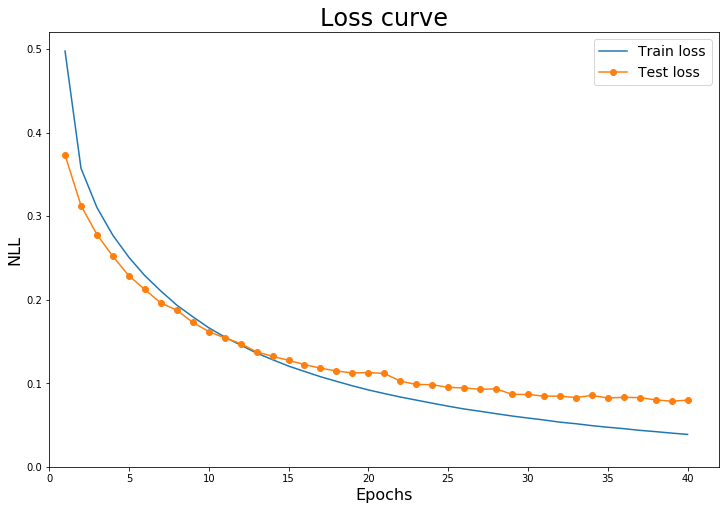

In [32]:
# Draw training loss curve
fig = plt.figure(figsize=(12, 8))
plt.plot(range(1, max_epochs + 1), train_losses, label='Train loss')
plt.plot(range(1, max_epochs + 1), test_losses, label='Test loss', marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Loss curve', fontsize=24)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

(40, 4)
     epochs   layers  gradient_norms
0         1  Layer 1        0.792060
1         2  Layer 1        0.875295
2         3  Layer 1        0.893819
3         4  Layer 1        0.898508
4         5  Layer 1        0.897839
..      ...      ...             ...
155      36  Layer 4        0.270867
156      37  Layer 4        0.261647
157      38  Layer 4        0.260294
158      39  Layer 4        0.256990
159      40  Layer 4        0.247954

[160 rows x 3 columns]


Text(0, 0.5, 'Gradient Norms')

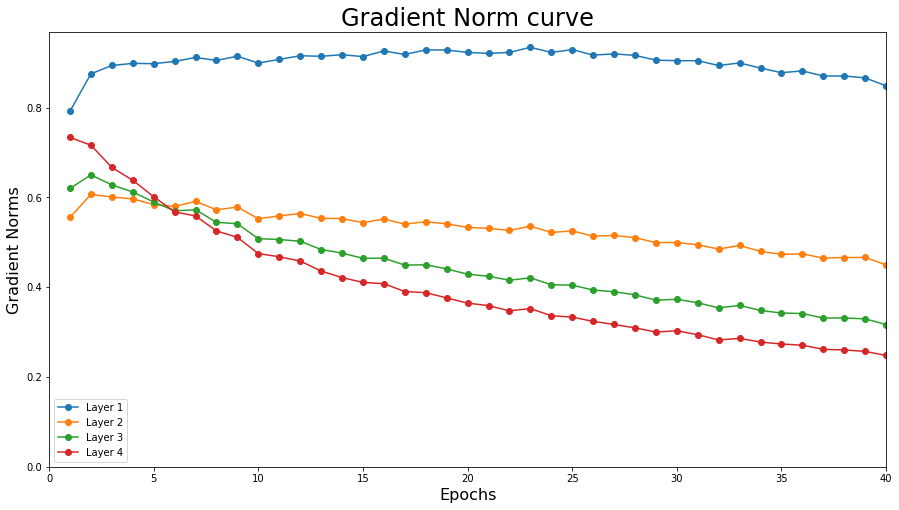

In [121]:
# Plot the gradient norms of each layer vs the number of epochs
# ------------------
# Write your implementation here.
# print(gradient_norms)

gradient_df = pd.DataFrame(gradient_norms, columns=['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4'])
# for i in range(40):
# index a column named 'epochs', Returns pd.Series
gradient_df['epochs']=[i+1 for i in range(40)]

# Reshaping DataFrame into a format where one or more columns are identifier varaibles

# Reference: https://www.geeksforgeeks.org/reshape-a-pandas-dataframe-using-stackunstack-and-melt-method/

gradient_df = gradient_df.melt('epochs', var_name='layers',  value_name='gradient_norms')
print(gradient_df)

fig, ax = plt.subplots(figsize=(15, 8))
gradient_df.groupby("layers").plot(x="epochs", y="gradient_norms", marker="o", ax=ax)
ax.legend(["Layer 1","Layer 2", "Layer 3", "Layer 4"])
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Gradient Norm curve', fontsize=24)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Gradient Norms', fontsize=16)

# # ------------------

### Problem 2
### 2a) Hand written and scanned

### 2b) Note that the rank of *U* is equal to *R*. In this part, we assume that *R = r*. Write a python file to implement the gradient descent algorithm. Let $t >=1$ denote the current epoch. Plot the distance between $U_tU_t^T$  and $X^*$ as a function of t. Note: (i) use the following parameters in the implementation, $d = 100, r = 5, m = 10.d.r$. (ii) The distance between two matrices *U* and *V* is the Frobenius norm of *U - V*.

In [66]:
# Initializing given parameters
d =100
r =5
# m = 10*d*r
m = 5000 

# Semidefnite Matrix 
# X* = U*U*^T
A = np.random.rand(d,r)

X = np.dot(U,U.transpose())

U = np.random.rand(d,r)

# The label of Ai, denoted by yi, is equal to yi = <Ai,Xi>

y_i = []
a_i = []

#  For each sample i = 1,2,..,m, let A_i be a random matrix where every entry of A_i is drawn independently 
# from a Gaussian distribution with zero mean and unit variance.

for i in range(m):
    a = np.random.normal(0,1,size=(d,d))
    y_i.append(np.inner(a,X))
    a_i.append(a)

In [68]:
U_append = []
distance = []
count = []
c = 0

for i in range(2000):
    res = np.zeros((d,r))
    for j in range(m):
        # Gradient descent of F(U) from problem 2a
        # norm = 2*(np.dot((np.inner(a_i[j],np.dot(U,U.T)))-y_i[j],(a_i[j]+a_i[j].T)))
        norm = 2*(np.dot(np.dot(np.inner(a_i[j], np.dot(U,U.T))-y_i[j],(a_i[j]+a_i[j].T)),U))
        res = np.add(res,norm)
    
    U = U-((0.0001/m)*(res))
    # Calculating distance between two matrices
    distances = np.linalg.norm(X-np.dot(U,U.transpose()))
    count.append(c)
    distance.append(distances)
    
    if distances <= 0:
        break;
    c+=1

Text(0, 0.5, 'Distance')

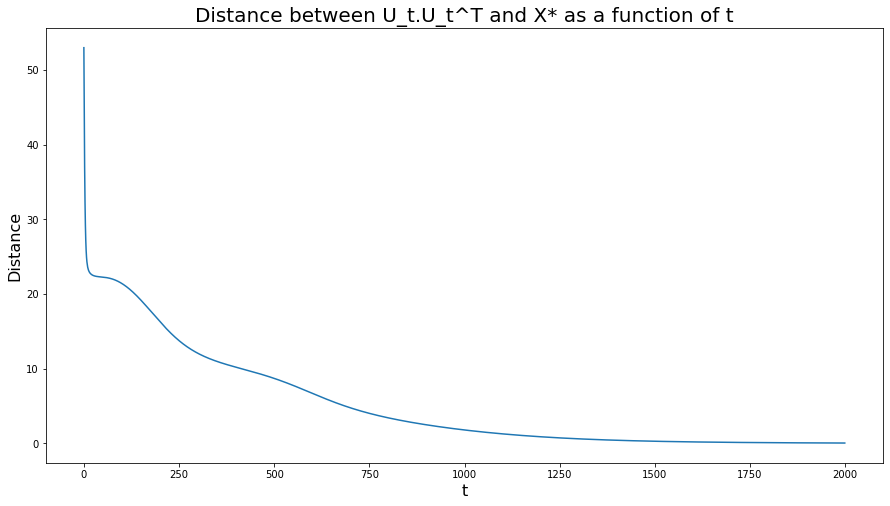

In [71]:
fig, ax = plt.subplots(figsize=(15, 8))
ax= plt.plot(count, distance)
# plt.xlim(left=0)
# plt.ylim(bottom=0)
plt.title('Distance between U_t.U_t^T and X* as a function of t', fontsize=20)
plt.xlabel('t', fontsize=16)
plt.ylabel('Distance', fontsize=16)

### 2c) Hand written and scanned

### 2(d) In this part, we assume that the gradient descent algorithm is over-parametrized. More specically, suppose that *R = d > r*. We consider different initialization to the gradient descent algorithm. Suppose that *W* is a random initialization where every entry of *W* is sampled independently from a Gaussian distribution with mean zero and unit variance. Use initialization $U_0 = alpha.W$, for $alpha$ from $10E-5, 10E-4, 10E-3, 10E-2, 10E-1$. Plot the distance between $U_tU_t^T$ and $X*$ for each initialization $U_0$ as a function of *t*.

In [131]:
A = np.random.rand(d,r)
X = np.dot(A,A.transpose())
W = np.random.rand(d,d)

y_i=[]
a_i=[]
U = []
U.append((10.e-1)*W)
U.append((10.e-2)*W)
U.append((10.e-3)*W)
U.append((10.e-4)*W)
U.append((10.e-5)*W)

distance_arr = []
counter_arr = []

for i in range(m):
    a = np.random.normal(0,1,size=(d,d))
    y_i.append(np.inner(a,X))
    a_i.append(a)

In [132]:
for k in range(0,5):
    u = U[k]
    dist = []
    count = []
    c = 0
    for i in range(1000):
        res = np.zeros((d,d))
        for j in range(m):
            norm = 2*(np.dot(np.dot(np.inner(a_i[j], np.dot(u,u.T))-y_i[j],(a_i[j]+a_i[j].T)),u))
            res = np.add(res,norm)
        
        u = u-((0.0001/m)*(res))
        distance = np.linalg.norm(X-np.dot(u,u.T))
        count.append(c)
        dist.append(distance)
        
        if distance<=0:
            break;
        
        c+=1
        
    distance_arr.append(dist)
    counter_arr.append(count)

In [133]:
print(len(counter_arr[0]))

1000


In [134]:
dist_arr = np.array(distance_arr)
count_arr = np.array(counter_arr)
print(dist_arr.shape)

df['Distance'] = pd.DataFrame(data=dist_arr.flatten())
df2['Counter'] = pd.DataFrame(data= count_arr.flatten())
df_final = pd.merge(df, df2, left_index=True, right_index=True)
df_final = df_final.drop(columns=['0_x', '0_y'])
print(df_final)



(5, 1000)
         Distance  Counter
0      143.491839      0.0
1      142.599941      1.0
2      141.723615      2.0
3      140.858238      3.0
4      139.999930      4.0
...           ...      ...
13995         NaN      NaN
13996         NaN      NaN
13997         NaN      NaN
13998         NaN      NaN
13999         NaN      NaN

[14000 rows x 2 columns]


Text(0, 0.5, 'Distance')

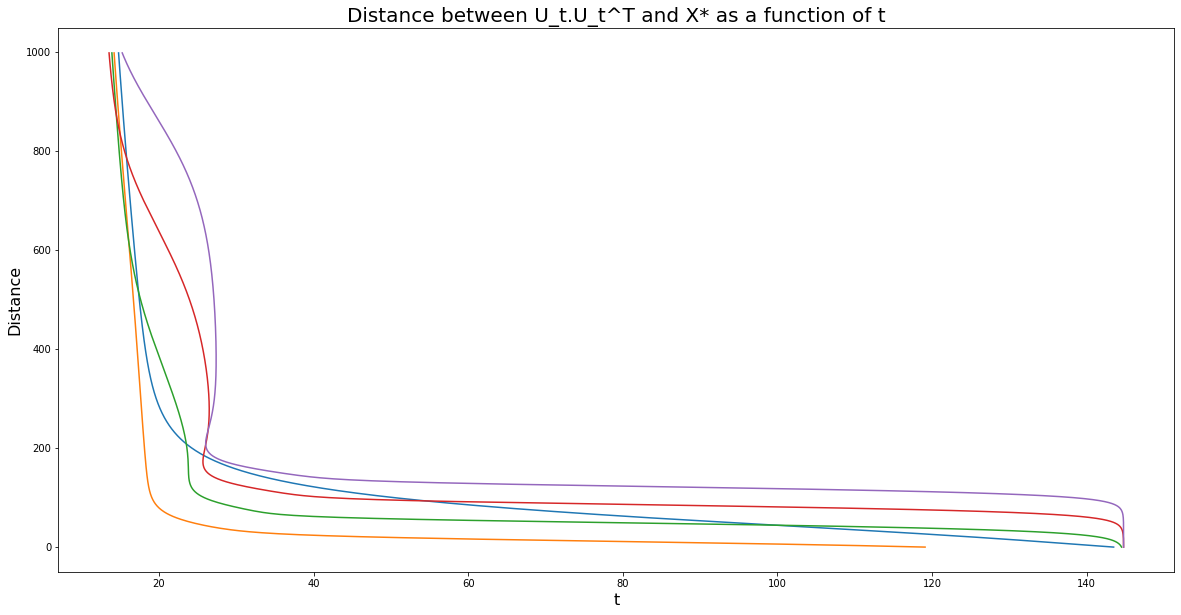

In [135]:
fig = plt.figure(figsize=(20, 10))
plt.plot(distance_arr[0],counter_arr[0],label="10e-1*w")
plt.plot(distance_arr[1],counter_arr[1],label="10e-2*w")
plt.plot(distance_arr[2],counter_arr[2],label="10e-3*w")
plt.plot(distance_arr[3],counter_arr[3],label="10e-4*w")
plt.plot(distance_arr[4],counter_arr[4],label="10e-5*w")
# # plt.ylim(bottom=0)
plt.title('Distance between U_t.U_t^T and X* as a function of t', fontsize=20)
plt.xlabel('t', fontsize=16)
plt.ylabel('Distance', fontsize=16)


### 2(e) Describe what the implicit regularization hypothesis is. What does the hypothesis suggest in the setting of part (d)? To verify whether this hypothesis is correct or not, plot the top ten largest singular values of $U_t$ as $t$ grows.

Reference Suriya Gunasekar, Blake Woodworth, Srinadh Bhojanapalli, Behnam Neyshabur, and Nathan Srebro. Characterizing Implicit Bias in Terms of Optimization Geometry 

"In overparameterized models where the training objective has many global minima, optimizing using a specific algorithm, such as gradient descent, implicitly biases the solutions to some special global minima. The properties of the learned model, including its generalization performance, are thus crucially influenced by the choice of optimization algorithm used. 

In neural networks especially, characterizing these special global minima for common algorithms such as stochastic gradient descent (SGD) is essential for understanding what the inductive bias of the learned model is and why such large capacity networks often show remarkably good generalization even in the absence of explicit regularization (Zhang et al., 2017) or early stopping (Hoffer et al., 2017).

Implicit bias from optimization depends on the choice of algorithm, and changing the algorithm, or even changing associated hyperparameter can change the implicit bias. For example, Wilson et al. (2017) showed that for some standard deep learning architectures, variants of SGD algorithm with different choices of momentum and adaptive gradient updates (AdaGrad and Adam) exhibit different biases and thus have different generalization performance"

Let $H_m$ be the hypotesis space.

$A: S -> H_m$ is an algorithm to solve the following un-regularized problem:

$$\min_{h \in H_m} {R_n(h)}$$

Consider the overparameterized setting, i.e., there exists many solutions such as $R_n(h) = 0$

* Implicit bias: The property that A always picks up certain solutions.
* Implicit Regularization: The property that A always picks up solutions with small population risk.

Therefore, in part 2d, we assume that the gradient descent is over parameterized. Changing the hyperparameter and tuning them like considering different initialization all together, changes the implicit bias.

In [138]:
W = np.random.rand(d,d)
U = (10.e-2)*W
singular_values = []

for i in range(1000):
    res = np.zeros((d,d))
    for j in range(m):
        norm = 2*(np.dot(np.dot(np.inner(a_i[j], np.dot(u,u.T))-y_i[j],(a_i[j]+a_i[j].T)),u))
        res = np.add(res,norm)
        
    U = U -((0.0001/m)*(res))
    u,sv, val = np.linalg.svd(U,full_matrices=True)
    singular_values.append(sv[0:10])

In [139]:
singularval_graph = []
for i in range(10):
    sv_arr = []
    for j in range(1000):
        sv_arr.append(singular_values[j][i])
    singularval_graph.append(sv_arr)

singularval_graph = np.asarray(singularval_graph)
t = np.linspace(1,1000,1000,dtype=int,endpoint=True)

Text(0, 0.5, 'Top 10 singular values')

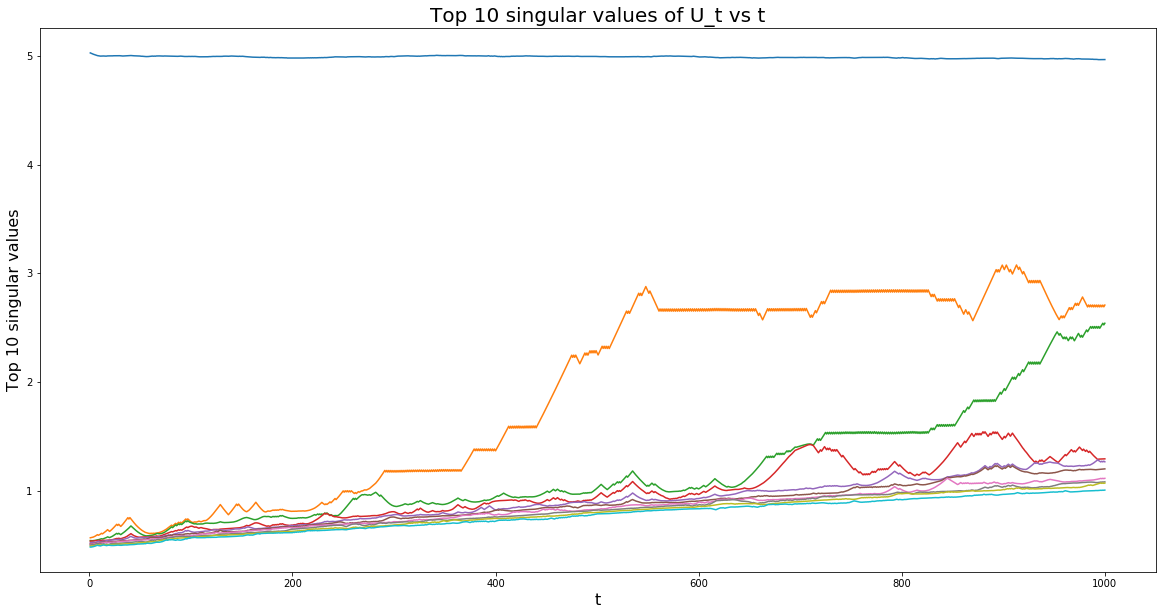

In [140]:
fig = plt.figure(figsize=(20, 10))
plt.plot(t,singularval_graph.T)
plt.title('Top 10 singular values of U_t vs t', fontsize=20)
plt.xlabel('t', fontsize=16)
plt.ylabel('Top 10 singular values', fontsize=16)
